<div>
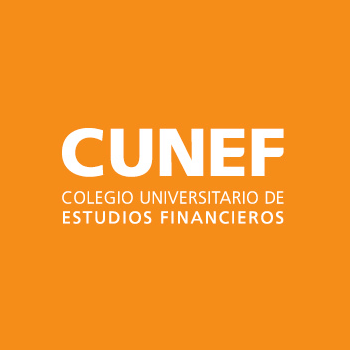
</div>

# **Índice de Precios al Consumidor España**

## *Librerías*

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación de los datos*
Se procede a leer el archivo CSV del Índice del Precio al Consumidor en España.

- Fuente: https://www.ine.es/consul/serie.do?d=true&s=IPC206448&c=2&&nocab

In [10]:
df_ipc = pd.read_csv("ipc.csv", sep = ";")
df_ipc

,Variable1,Valor1,Variable2,Valor2,Variable3,Valor3,PERIODO,VALOR
0,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2021M12,"6,5"
1,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2021M11,"5,5"
2,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2021M10,"5,4"
3,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2021M09,"4,0"
4,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2021M08,"3,3"
...,...,...,...,...,...,...,...,...
95,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2014M01,"0,2"
96,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2013M12,"0,3"
97,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2013M11,"0,2"
98,Tipo de dato,Variación anual,Total Nacional,Total Nacional,Grupos ECOICOP,Índice general,2013M10,"-0,1"


Seleccionamos la variable de los valores del índice, indexamos el periodo y pasaremos su formato con la funcionalidad de Pandas "to_datetime". Por último, para que seaborn nos pueda representar bien los índices históricos, cambiaremos las comas de las decimales por puntos:

In [11]:
df_ipc = df_ipc.iloc[:,-2:]

In [12]:
df_ipc['PERIODO'] = df_ipc['PERIODO'].str.replace('M', '')
df_ipc['PERIODO'] = pd.to_datetime(df_ipc['PERIODO'], format='%Y%m')
df_ipc = df_ipc.set_index("PERIODO")
df_ipc


,VALOR
PERIODO,
2021-12-01,"6,5"
2021-11-01,"5,5"
2021-10-01,"5,4"
2021-09-01,"4,0"
2021-08-01,"3,3"
...,...
2014-01-01,"0,2"
2013-12-01,"0,3"
2013-11-01,"0,2"


In [13]:
df_ipc['VALOR']=df_ipc['VALOR'].str.replace(',', '.').astype(float)
df_ipc

,VALOR
PERIODO,
2021-12-01,6.5
2021-11-01,5.5
2021-10-01,5.4
2021-09-01,4.0
2021-08-01,3.3
...,...
2014-01-01,0.2
2013-12-01,0.3
2013-11-01,0.2


## *Graficación de la serie temporal*

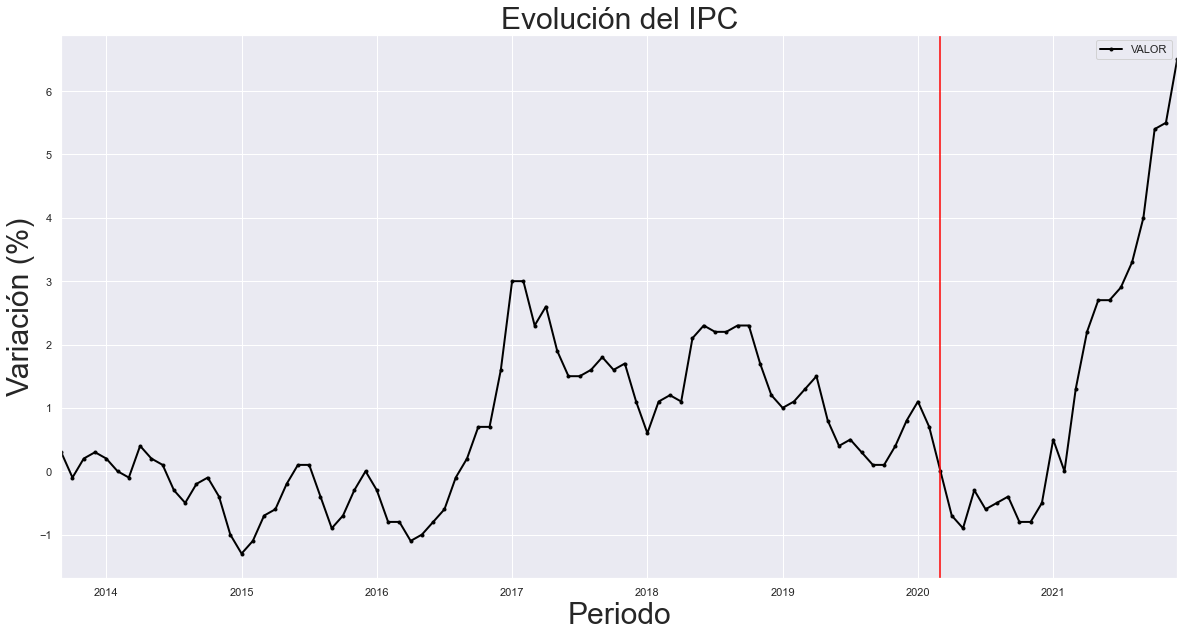

In [19]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_ipc.plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Evolución del IPC', fontsize = 30)
fig.set_ylabel('Variación (%)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

Podemos ver en la gráfica varias tendencias distintas a lo largo del periodo comprendido:
- Una primera parte, que comprende desde septiembre del 2013 hasta abril del 2016, en el que hay una tendencia decreciente con varios picos de subidas del índice.
- Otra tendencia comprendida desde abril del 2016 hasta finales del 2019, donde hay una tendencia creciente.
- Otra tendencia comprendida desde finales del 2019 hasta mediados del año 2020, justo en el momento de la pandemia por COVID-19.
- La última tendencia que se lleva a cabo desde mediado del 2020 hasta hoy en día, donde se aprecia que tiene un comportamiento muy creciente. Esto es debido al encarecimiento de algunos valores como ea el petróleo, la luz o el alquiler o compra de viviendas. 

A continuación, analizaremos la estacionalidad mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

In [15]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [16]:
media = split_and_summarize(df_ipc, 'VALOR', 4, np.mean)

varianza = split_and_summarize(df_ipc, 'VALOR', 4, np.var)

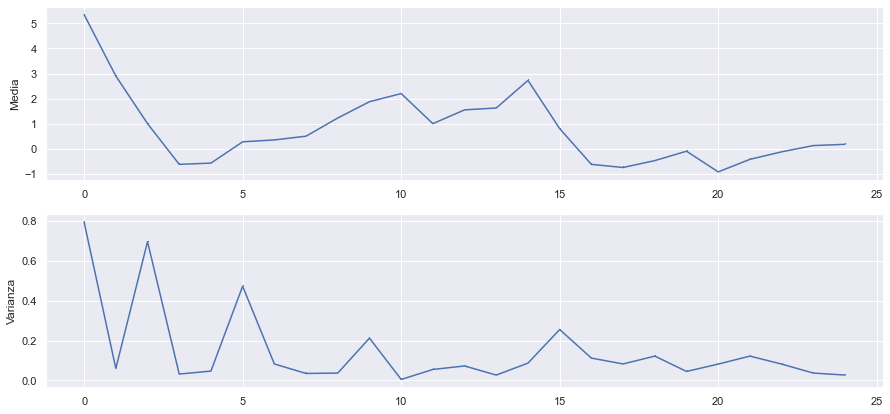

In [17]:
cols = ['media', 'varianza']
df = pd.DataFrame([media, varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()

# <font color = red> CORREGIR ESTE FALLO </font>

ValueError: Expected frequency -1MS. Got M

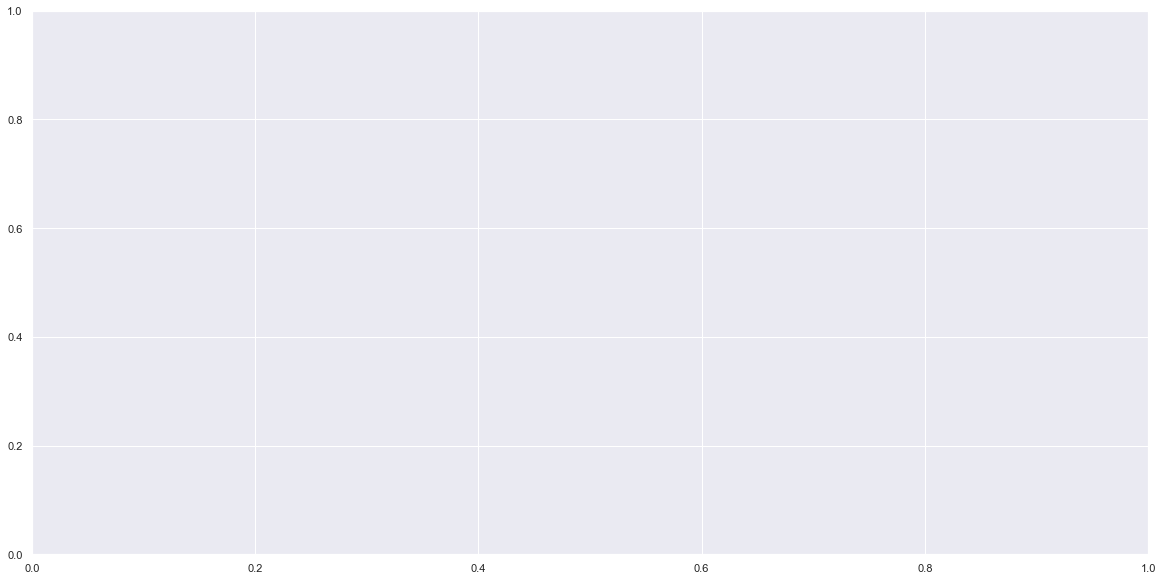

In [24]:
# Componente estacional mensual:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_ipc['VALOR'], ax = ax)
ax.set_title('Comportamiento mensual', fontsize = 30);

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

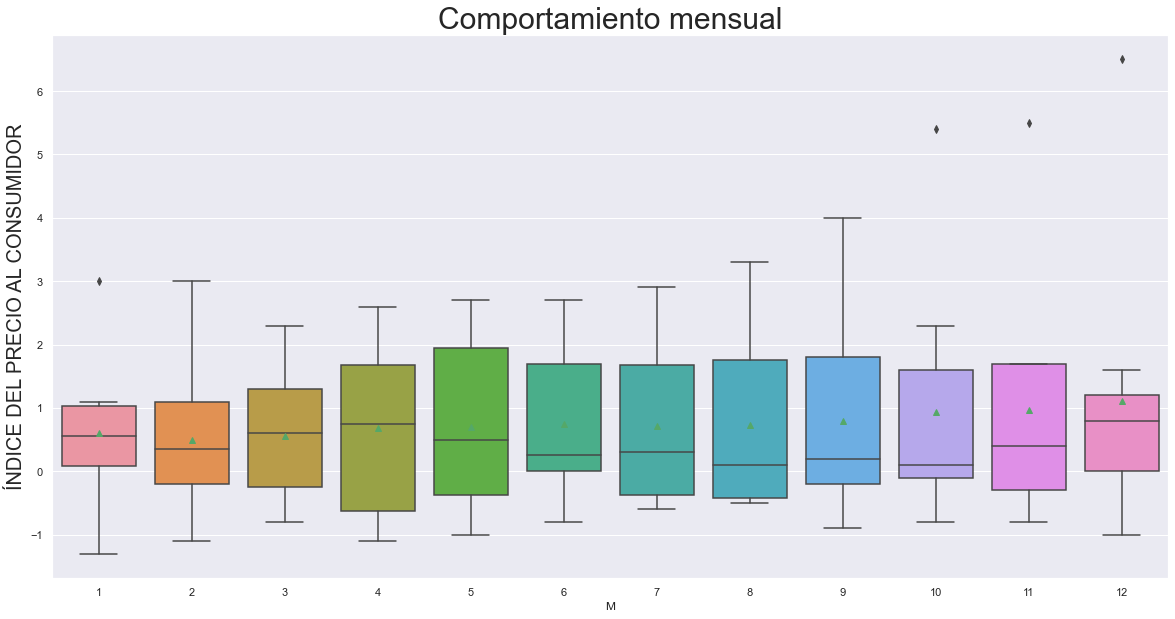

In [21]:
df_ipc['M'] = df_ipc.index.month
sns.boxplot(data = df_ipc, x = 'M', y='VALOR', showmeans=True)
ax = plt.gca()
ax.set_ylabel('ÍNDICE DEL PRECIO AL CONSUMIDOR', fontsize = 20)
ax.set_title('Comportamiento mensual', fontsize = 30);

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

# <font color = red> EL PERIODO SALE AL REVÉS, CORREGIRLO </font>

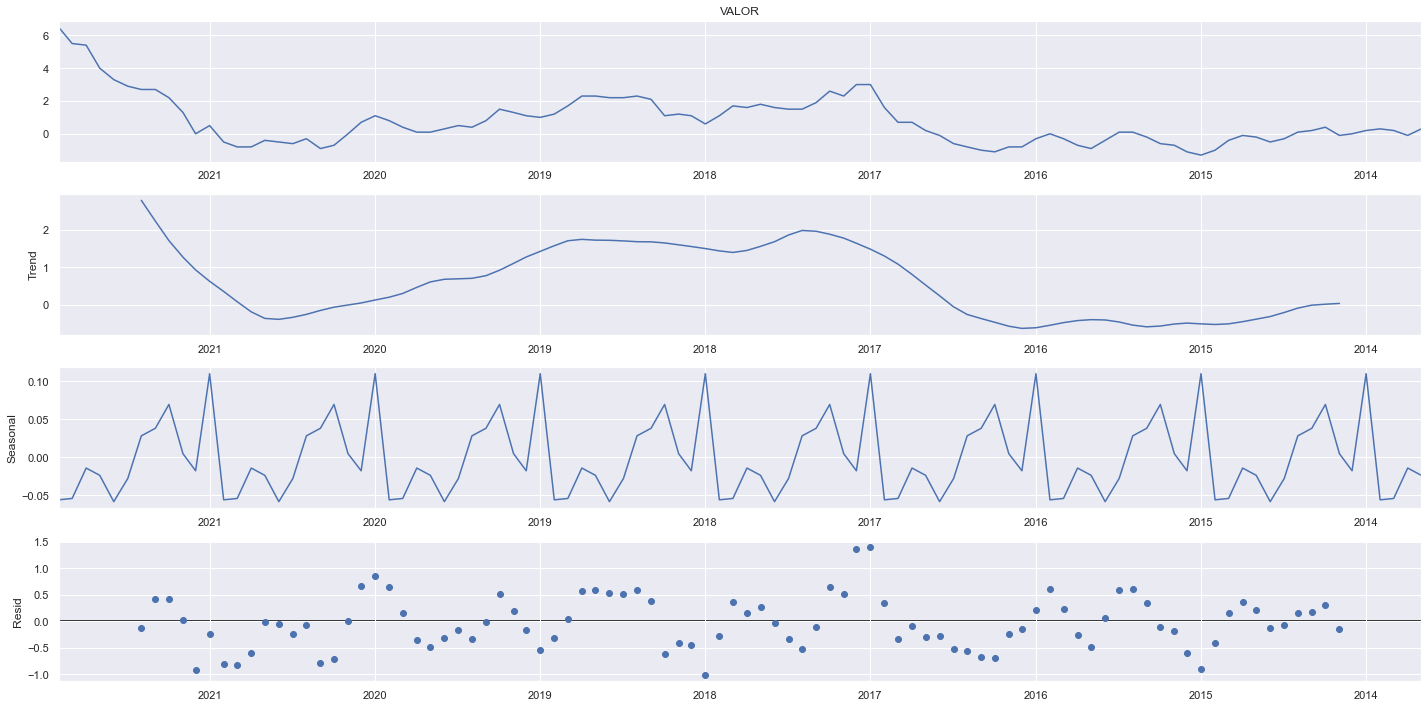

In [35]:
desglose = seasonal_decompose(df_ipc['VALOR'], 
                                   model='additive', period=12);
desglose.plot();

Analizando sus gráficas, podemos ver que:
- La tendencia es como lo que comentamos al principio: hay primero un descenso ligero desde 2013 hasta abril del 2016, luego una tendencia creciente que se mantiene hasta finales del 2019. Posteriormente, un descenso del índice hasta mediados del 2021, en el que se cambia a una tendencia creciente muy pronunciada derivado de la subida del precio de algunos bienes y servicios básicos en España. 
- No presenta movimientos de oscilación dentro del año de manera fija y continuada, por lo que deducimos que no posee estacionalidad. Además, la representación gráfica de la media y de la varianza no poseen constancia ninguna, por lo que esta serie temporal tampoco es estacionaria.
- Parece que en el comportamiento mensual, el índice se mueve de una manera similar durante todos los meses del año.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.